# Model Training
Uses TensorFlow and Keras to train a model from a dataset, exports model. Intended to be run once, and model is intended to be exported.
Source: keras documentation, https://keras.io/examples/vision/handwriting_recognition/

In [1]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

mkdir: data: File exists
mkdir: data/words: File exists


# Imports + Seed
## Imports:
- StringLookup from keras. Part of preprocessing layer, encodes/tokenizes characters
- matplotlib. Graphing
- tensorflow. ML, includes keras
- numpy. Number processing stuff.
- os. Operating system stuff.

## Note about seed
Numpy has its own specific algorithm for its random number generator. That algorithm has an input, and if the exact same input is given, the exact same set of random numbers will appear in the output. (source: https://keras.io/examples/vision/handwriting_recognition/)
The documentation includes two lines that set the seed value. I have no idea why.

In [3]:
from tensorflow.keras.layers import StringLookup

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# see note above
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


# Parsing
## Info about parsing
As seen above, the file words.txt has a list of image names and the matching output. Some of the files have "err" as a status instead of "ok," so we're skipping those words.
In the cell below, we read through words.txt, add the entries to a list (known as words_list), and then finding the filenames and training the data.

In [5]:
base_path = "data" # folder where data is stored
words_list = []

# open words.txt file, ignore comments, ignore "err" labels, add to wordlist
words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

Split data into training, validation, and testing. 90:5:5 ratio.

In [6]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [7]:
base_image_path = os.path.join(base_path, "words")

'''
hierarchy:

words
├── a01
|   ├── a01-000u
|   |   ├── a01-000u-00-00.png

get_image_paths_and_labels parses through the labels and converts them into paths
'''


def get_image_paths_and_labels(samples):
    """
    Keyword argument:
    samples--list of lines from words.txt. 
        Represents either training, val, or test data
    """
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()      # remove spaces from ends
        line_split = line_split.split(" ")  # split by space

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]          # ex: a01-000u-00-00
        partI = image_name.split("-")[0]    # ex: a01, first folder
        partII = image_name.split("-")[1]   # ex: 000u, ending of second folder
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        ) 
        # "data/words" + "a01" + "ao1-000u" + "a01-000u-00-00.png"
        if os.path.getsize(img_path):
            paths.append(img_path) # "data/words/a01/ao1-000u/a01-000u-00-00.png"
            # original, ex "a01-000u-00-00 ok 154 408 768 27 51 AT A"
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

Training data:
Prepare labels for each image (ending expression in "words.txt"). Find max length

In [8]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()                          # O(1) time, all chars in training data
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()    # label for image
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))      # continuously find max length
    train_labels_cleaned.append(label)      # add word label to list

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

Validation and test data: clean

In [9]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

Building character vocab

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

Function to resize image:

In [14]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize_with_pad(image, h, w)
    # documentation had a different thing with 
    # tf.image.resize, find padding diff, then tf.pad
    # found this function instead and I guess it works fine

    # lines below convert from vertical to horizontal, then flips to correct orientation
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1) # 1: output to grayscale. tensor of uint8 or uint16
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 # cast to float instead of int
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) # call StringLookup layer
    # resize label layer to fit max size
    length = tf.shape(label)[0]
    pad_amount = max_len - length 
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_image_labels(image_path, label):
    # calls above functions, gets preprocessed image and label, returns as dict
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    # calls all functions above, makes tf dataset with image paths, 
    # maps image paths and labels to tf images and tf labels
    # TODO look up AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_image_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [15]:
train_ds = prepare_dataset(
    train_img_paths, 
    train_labels_cleaned
)
validation_ds = prepare_dataset(
    validation_img_paths, 
    validation_labels_cleaned
)
test_ds = prepare_dataset(
    test_img_paths, 
    test_labels_cleaned
)

Visualize images to verify padding and encoding has been done correctly

2024-01-12 22:53:29.476145: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


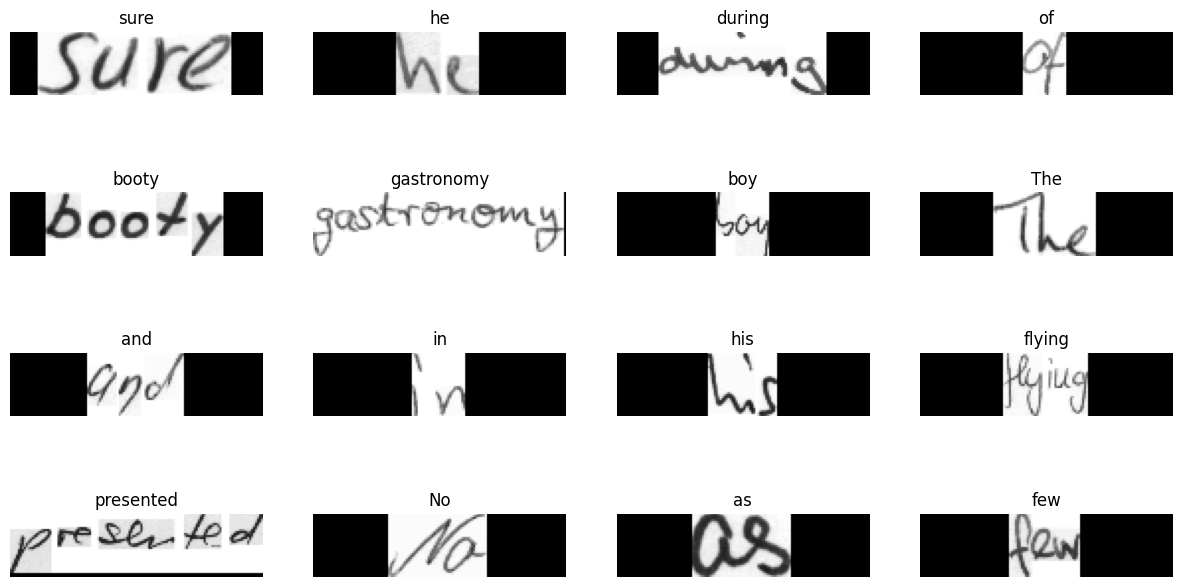

In [17]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8) # convert to np array
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # convert to string
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

Training model, using Connectionist Temporal Classification (CTC) loss
Keras documentation linked this artcle describing CTC loss: https://distill.pub/2017/ctc/
My notes:
- used when input X and input Y don't have consistent lengths or ratios or correspondence between each other. 
    - Ex: audio -> transcript, audio length is diff from transcript length, we don't know which audio portion corresponds to which transcript portion
- find probability that Y matches with X, gradient descent to minimize loss
- creates blank token between distinct characters, ϵ

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__ (self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        